# Easc 305: Spatial Analysis (Part 3)  
---
# Kriging 

In [1]:
%matplotlib notebook 

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font',   size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes',   titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('ytick',  labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Demo 1: Experimental variograms

In [2]:
# x,y,z triplets
data = sio.loadmat('geost_dat.mat')
x    = data['x'][0:140].astype(np.float)
y    = data['y'][0:140].astype(np.float)
z    = data['z'][0:140].astype(np.float)

Plot data locations in $x$ and $y$, and visual inspection of $z$ distribution  

<IPython.core.display.Javascript object>


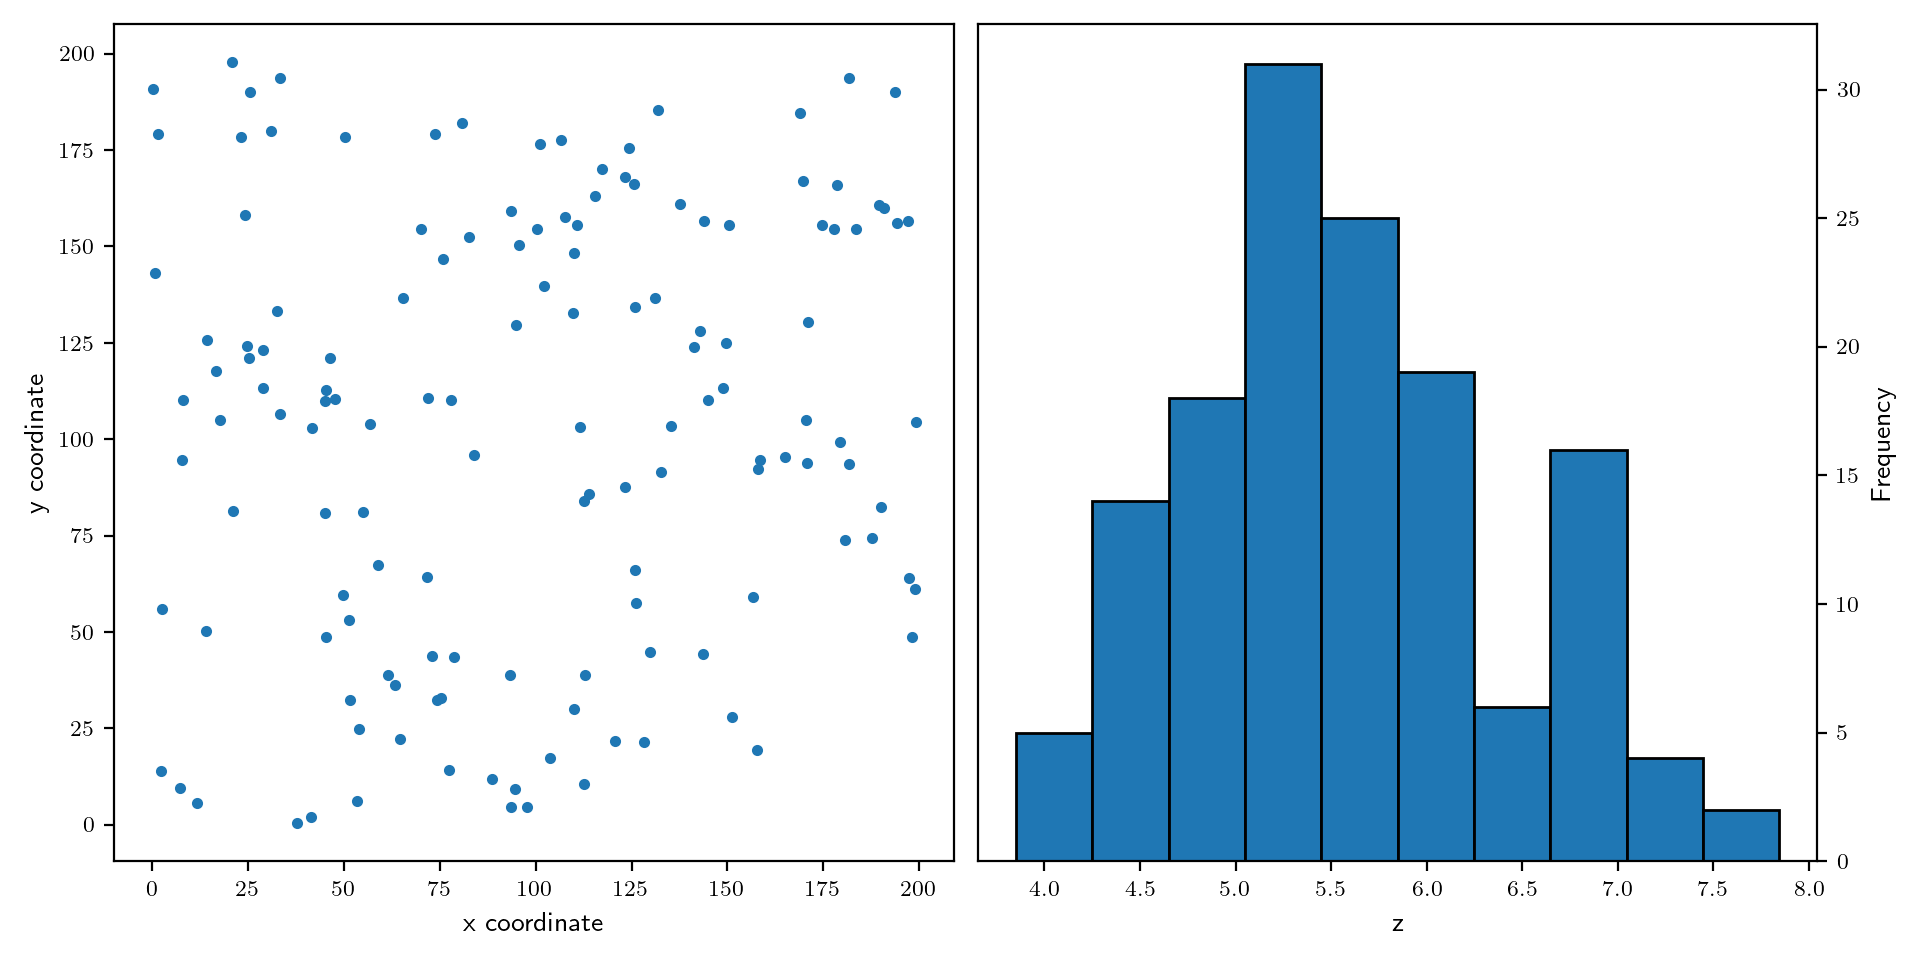

In [3]:
fig, ax = plt.subplots(1,2,figsize=(9.6,4.8))

ax[0].scatter(x,y,marker='.')
ax[0].set_ylabel('y coordinate')
ax[0].set_xlabel('x coordinate')

_ = ax[1].hist(z,edgecolor='k')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('z')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

fig.tight_layout()

## Create Data Pairs

In [4]:
# Construct arrays that include all combinations of data pairs
X1, X2 = np.meshgrid(x,x)
Y1, Y2 = np.meshgrid(y,y)
Z1, Z2 = np.meshgrid(z,z)

Let's see what we are doing here. Well create a simpler array `V` to visualize whats going on:

In [5]:
# V = np.array([1,2,3,4])
# V1, V2 = np.meshgrid(V,V)
# fig,ax = plt.subplots()
# ax.imshow((V1-V2)**2)

## Compute separation distances between all pairs:

In [6]:
D = np.sqrt( (X1-X2)**2 + (Y1-Y2)**2)

<IPython.core.display.Javascript object>


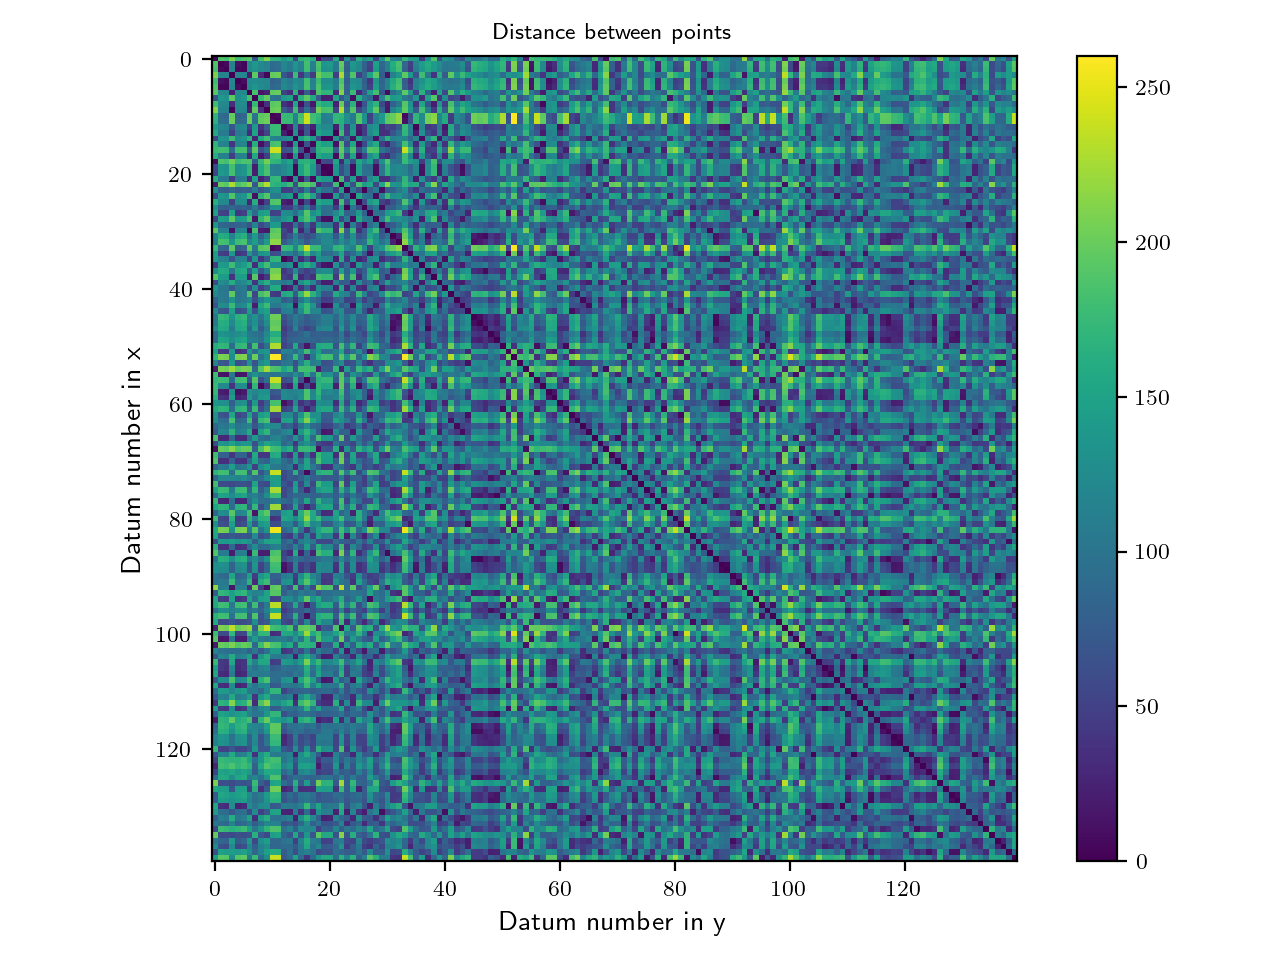

In [7]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(D)
ax.set_ylabel('Datum number in x')
ax.set_xlabel('Datum number in y')
ax.set_title('Distance between points')
fig.colorbar(im,ax=ax)

fig.tight_layout()

# Demo 3: Ordinary (punctual kriging)

We need to solve the equation: 

$$
\bf{W} {\Lambda} = B
$$

$$
\underbrace{
\begin{bmatrix}
    0               & \gamma(x_1,x_2) & \gamma(x_1,x_3) & \ldots &  \gamma(x_1,x_k) & 1 \\
    \gamma(x_2,x_1) &     0           & \gamma(x_2,x_3) & \ldots &  \gamma(x_2,x_k) & 1\\
    \gamma(x_3,x_1) & \gamma(x_3,x_2) &       0         & \ldots &  \gamma(x_3,x_k) & 1 \\
    \vdots          &  \vdots         & \vdots          & \ddots &     \vdots       & \vdots \\
    \gamma(x_k,x_1) & \gamma(x_k,x_2) & \gamma(x_k,x_3) & \ldots & 0                &  1\\
     1              &     1           &       1         &    1   & 1                & 0
    \end{bmatrix}
}_{\bf{W}} \;\;
%
\underbrace{
    \begin{bmatrix}
    \lambda_{1} \\
    \lambda_{2} \\
    \lambda_{3} \\
    \vdots \\
    \lambda_{3} \\
    \mu
    \end{bmatrix}
}_{\Lambda} =
%
\underbrace{
    \begin{bmatrix}
    \gamma(x_1,x_0) \\
    \gamma(x_2,x_0) \\
    \gamma(x_3,x_0) \\
    \vdots \\
    \gamma(x_k,x_) \\
    1
    \end{bmatrix}
}_{B}
.
$$

Solving for weights:
$$
\Lambda = \mathbf{W}^{-1} B 
$$

Compute estimates: 
$$
\hat z(x_0) = Z^{\rm T} \Lambda
$$

Compute kriging variance: 
$$
\sigma^2 = B^{\rm T} \Lambda
$$

__Populate semivariance matrix W based on exponential model__

In [8]:
nugget   = 0.02
sill     = 0.68
range    = 45
W        = nugget + sill*(1 - np.exp(-3*D/range))

# Add extra row and column to W for Lagrange multiplier
m, n     = W.shape 
W        = np.append(W,np.ones((1,m)),axis=0)   # Add final column of ones
W        = np.append(W,np.ones((n+1,1)),axis=1) # Add final row of ones
W[-1,-1] = 0     

In [9]:
# Invert W matrix for later
Winv = np.linalg.inv(W)

__Construct regular grid over which interpolated values are required__

In [10]:
xgrid = np.arange(0,205,5)
ygrid = np.arange(0,205,5)
X, Y  = np.meshgrid(xgrid,ygrid)

__Convert arrays to single vectors:__

In [11]:
Xvec = X.flatten()
Yvec = Y.flatten()

__Initialize variables:__

In [12]:
Zvec  = 99999.*np.ones((Xvec.shape[0],1))
S2vec = 99999.*np.ones((Xvec.shape[0],1))

__Computed kriged estimate at each point `i`__

In [13]:
#Computed kriged estimate at each point i
for i in np.arange(Xvec.shape[0]):
    # calculate distances between point of interest and all observations:
    D0 = np.sqrt( (x - Xvec[i])**2 + (y - Yvec[i])**2 )
    # calculate B (RHS) based on distances above and variogram model
    B = nugget + sill*(1 - np.exp(-3*D0/range))
    # Add final element for Lagrange multiplier
    B = np.append(B,1)
    # Compute kriging weights and lagrange multiplier with matrix multiplication
    Lambda   = np.dot(Winv,B)
    # Compute kriging estimate at point of interest as weighted sum of obs   
    Zvec[i]  = np.dot(z.T,Lambda[:n])
    # Compute kriging variance at point of interest
    S2vec[i] = np.dot(B.T,Lambda)
    
# Reshape results and plot  
M  = xgrid.shape[0]
Z  = Zvec.reshape(M,M)
S2 = S2vec.reshape(M,M)

__Plot the results__ 

<IPython.core.display.Javascript object>


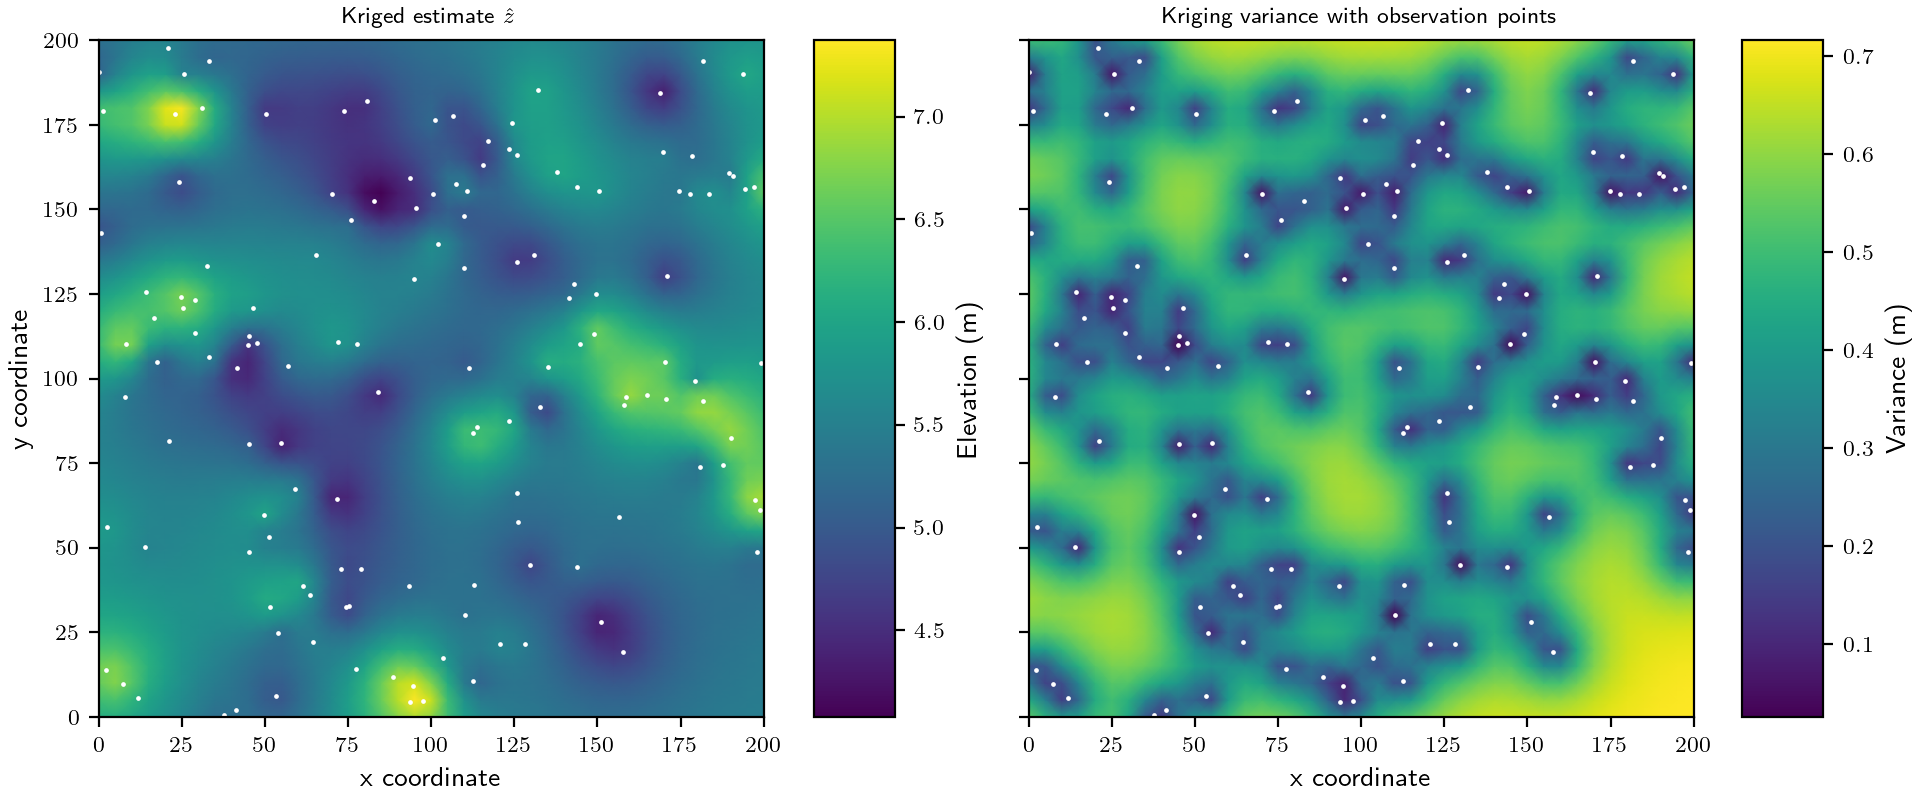

(0.0, 200.0)

In [16]:
fig, ax = plt.subplots(1,2,figsize=(9.6,4.0),sharex=True, sharey=True, constrained_layout=True)

im = ax[0].pcolormesh(X,Y,Z, shading='gouraud')
ax[0].scatter(x,y,marker='.',c='white',s=2)

fig.colorbar(im,ax=ax[0], label= 'Elevation (m)')
ax[0].set_title( 'Kriged estimate $\hat z$')
ax[0].set_ylabel('y coordinate')
ax[0].set_xlabel('x coordinate')

im = ax[1].pcolormesh(X,Y,S2,shading='gouraud')
ax[1].scatter(x,y,marker='.',c='white',s=2)

fig.colorbar(im,ax=ax[1], label= 'Variance (m)')
ax[1].set_title('Kriging variance with observation points')
ax[1].set_xlabel('x coordinate')
ax[1].set_xlim(0,200)
#fig.tight_layout()